# Finding the Best Classifier For a Dataset

This notebook is imported from a final project for the IBM Machine Learning Course on Coursera ([Here's the link to this course](https://www.coursera.org/learn/machine-learning-with-python/home/welcome)). In this project, I practiced all the classification algorithms that I learned in the course, as well as some essential Python programming techniques. 

A *Loan Record* dataset is loaded using Pandas library. I wrote codes to apply the four different types of algorithms, find the best version of these algorithms for this specific dataset, and finally, find the best algorithm for this dataset by accuracy evaluation methods.

The project starts by load required libraries:

In [3]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Download the dataset

In [4]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-08-02 03:11:17--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-08-02 03:11:17 (12.9 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [5]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [6]:
df.shape

(346, 10)

### Convert to date time object 

In [7]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



To see how many of each class is in this data set 

In [8]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Plot some columns to underestand data better:

In [9]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    certifi-2019.6.16          |           py36_0         154 KB  anaconda
    seaborn-0.9.0              |           py36_0         379 KB  anaconda
    ca-certificates-2019.5.15  |                0         133 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.7 MB

The following packages will be UPDATED:

    ca-certificates: 2019.5.15-0       --> 2019.5.15-0      anaconda
    certifi:         2019.6.16-py36_0  --> 2019.6.16-py36_0 anaconda
    openssl:         1.1.1c-h7b6447c_1 --> 1.1.1-h7b6447c_0 anaconda
    seaborn:         0.9.0-py36_0     

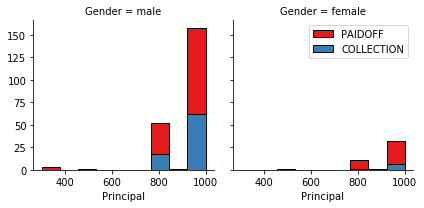

In [10]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

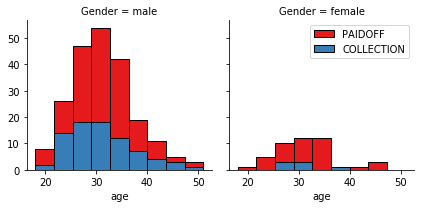

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Look at the day of the week people get the loan 

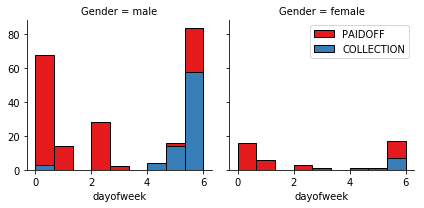

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


It is apparent that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Look at gender:

In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans while only 73 % of males pay there loan


Convert male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Define feature sets, X:

In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [20]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

The following section uses the training set to build an accurate model, then uses the test set to report the accuracy of the model.    
It uses the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

# K Nearest Neighbor(KNN)

In [22]:
# Import package for splitting
from sklearn.model_selection import train_test_split

# Split the dataset into 80% for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', x_train.shape[0],  y_train.shape[0])
print ('Test set:', x_test.shape[0],  y_test.shape[0])

Train set: 276 276
Test set: 70 70


In [23]:
# Import necessary packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Try 20 different k-values
Ks = 20
acc_score = np.zeros((Ks))

for n in range(1,Ks+1):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(x_train, y_train)
    yhat = neigh.predict(x_test)
    acc_score[n-1] = metrics.accuracy_score(y_test, yhat) # We use a simple accuracy score to show accuracy
    
print(acc_score)

[0.67142857 0.65714286 0.71428571 0.68571429 0.75714286 0.71428571
 0.78571429 0.75714286 0.75714286 0.67142857 0.7        0.72857143
 0.7        0.7        0.68571429 0.72857143 0.72857143 0.72857143
 0.7        0.68571429]


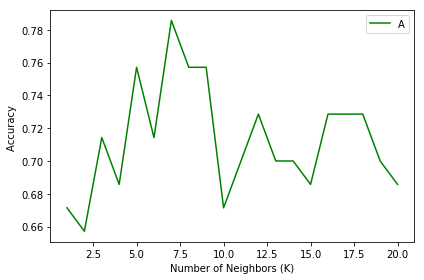

In [24]:
# Plot accuracy score for each K 
plt.plot(range(1,Ks+1),acc_score,'g')
plt.legend('Accuracy ')
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

According to the output and the plot, the best K-value for the model is 7, which yields an accuracy score of ~0.79. Therefore, we will be using **7** as the K-value in our model. 

In [25]:
knn_final = KNeighborsClassifier(n_neighbors = 7).fit(x_train, y_train)

# Decision Tree

In [26]:
# Import package for decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# Try 20 different k values
Ks = 20
acc_score = np.zeros((Ks))

for n in range(1,Ks+1):
    
    # Make a decision tree object, then fit the model 
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    loanTree.fit(x_train, y_train) # fitting the data
    
    # Predict the model, show accuracy score
    yHat = loanTree.predict(x_test)
    acc_score[n-1] = metrics.accuracy_score(y_test, yHat)

acc_score

array([0.78571429, 0.78571429, 0.61428571, 0.61428571, 0.64285714,
       0.77142857, 0.75714286, 0.75714286, 0.65714286, 0.7       ,
       0.68571429, 0.71428571, 0.71428571, 0.72857143, 0.72857143,
       0.68571429, 0.7       , 0.7       , 0.68571429, 0.7       ])

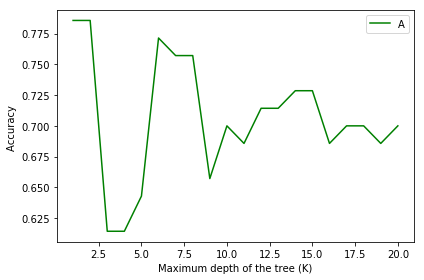

In [27]:
# Plot accuracy score for each K
plt.plot(range(1,Ks+1), acc_score, 'g')
plt.legend(('Accuracy '))
plt.ylabel('Accuracy ')
plt.xlabel('Maximum depth of the tree (K)')
plt.tight_layout()
plt.show()

Apparently, the model yields highest accuracy score when it has depth 1 or 2. Let's visualize both of them to see more details of the tree. 

In [28]:
# Import necassary packages
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-pyhd1c1de3_3 conda-forge

The following packages will be UPDATED:

    ca-certificates: 2019.5.15-0        anaconda    --> 2019.6.16-hecc5488_0 conda-forge
    certifi:         2019.6.16-py36_0   an

0.7857142857142857


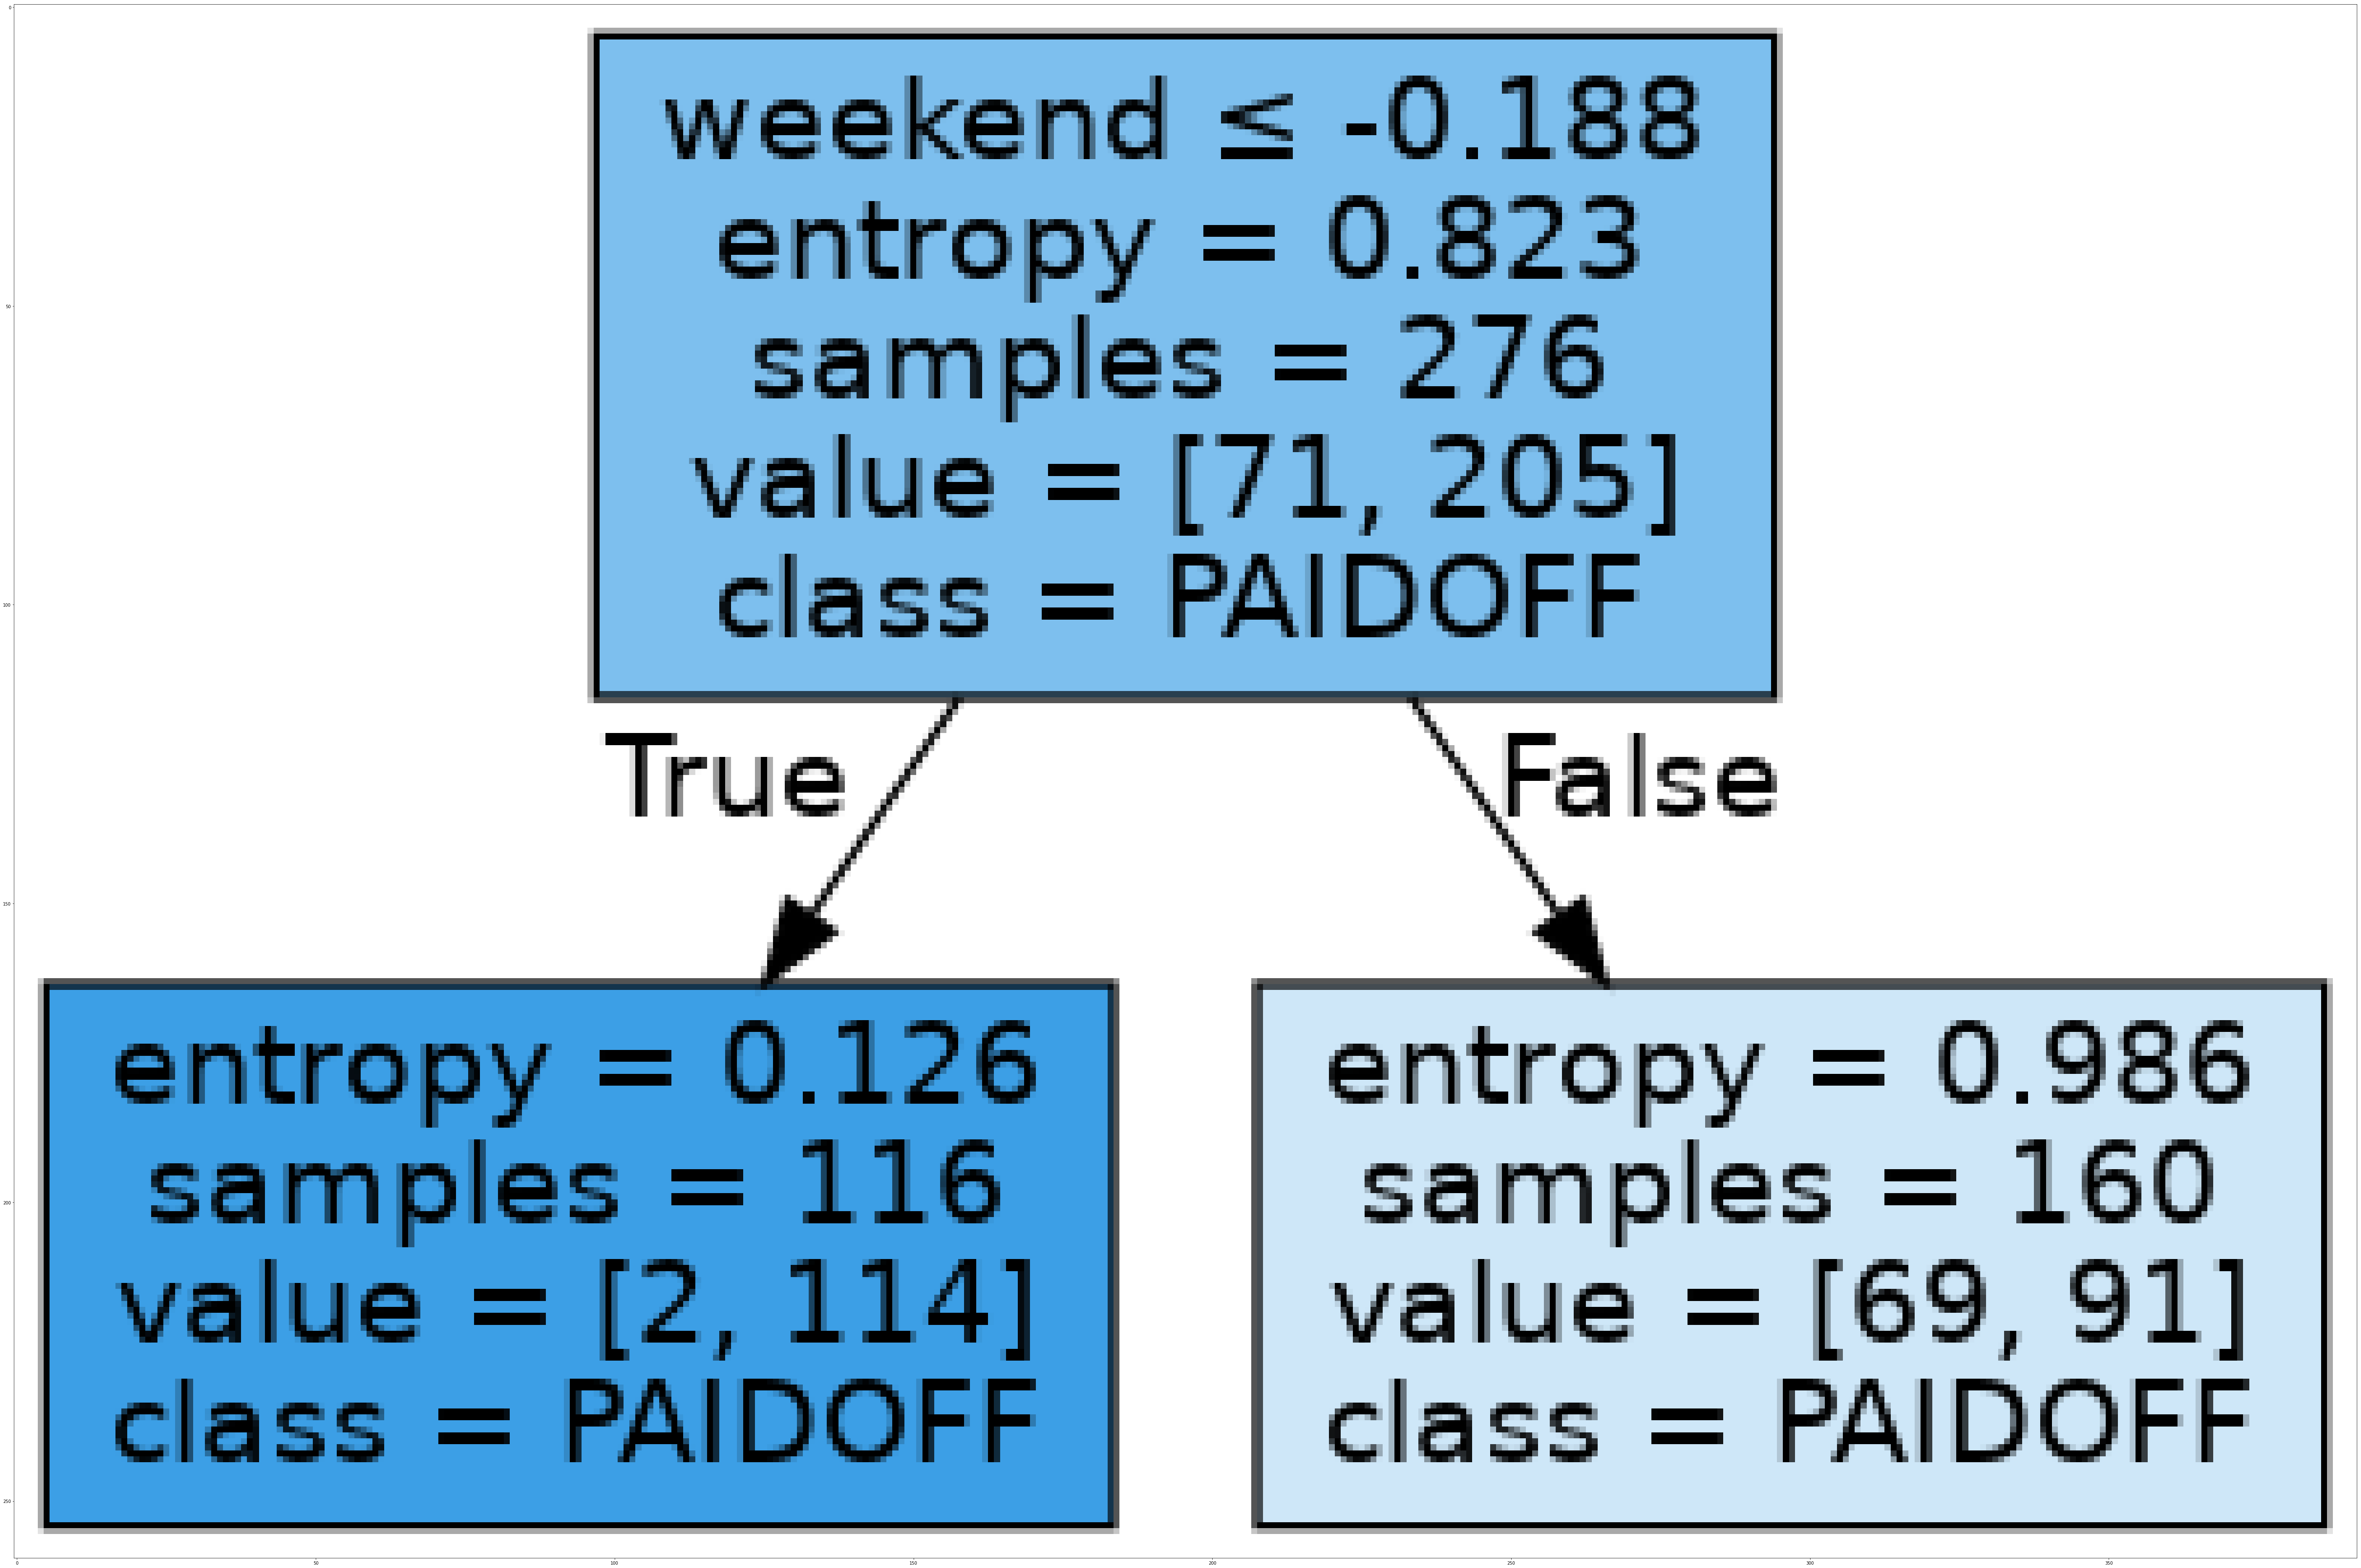

In [29]:
# Depth 1 tree
loanTree1 = DecisionTreeClassifier(criterion="entropy", max_depth = 1)
loanTree1.fit(x_train, y_train) # fitting the data
# Predict the model, show accuracy score
yHat = loanTree1.predict(x_test)
print(metrics.accuracy_score(y_test, yHat))

# Make the image
dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns
targetNames = df['loan_status'].unique().tolist()
out = tree.export_graphviz(loanTree1, feature_names = featureNames, 
                           out_file = dot_data, class_names = np.unique(y_train), 
                           filled = True,  special_characters = True,rotate = False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize = (100, 200))
plt.imshow(img, interpolation='nearest')

0.7857142857142857


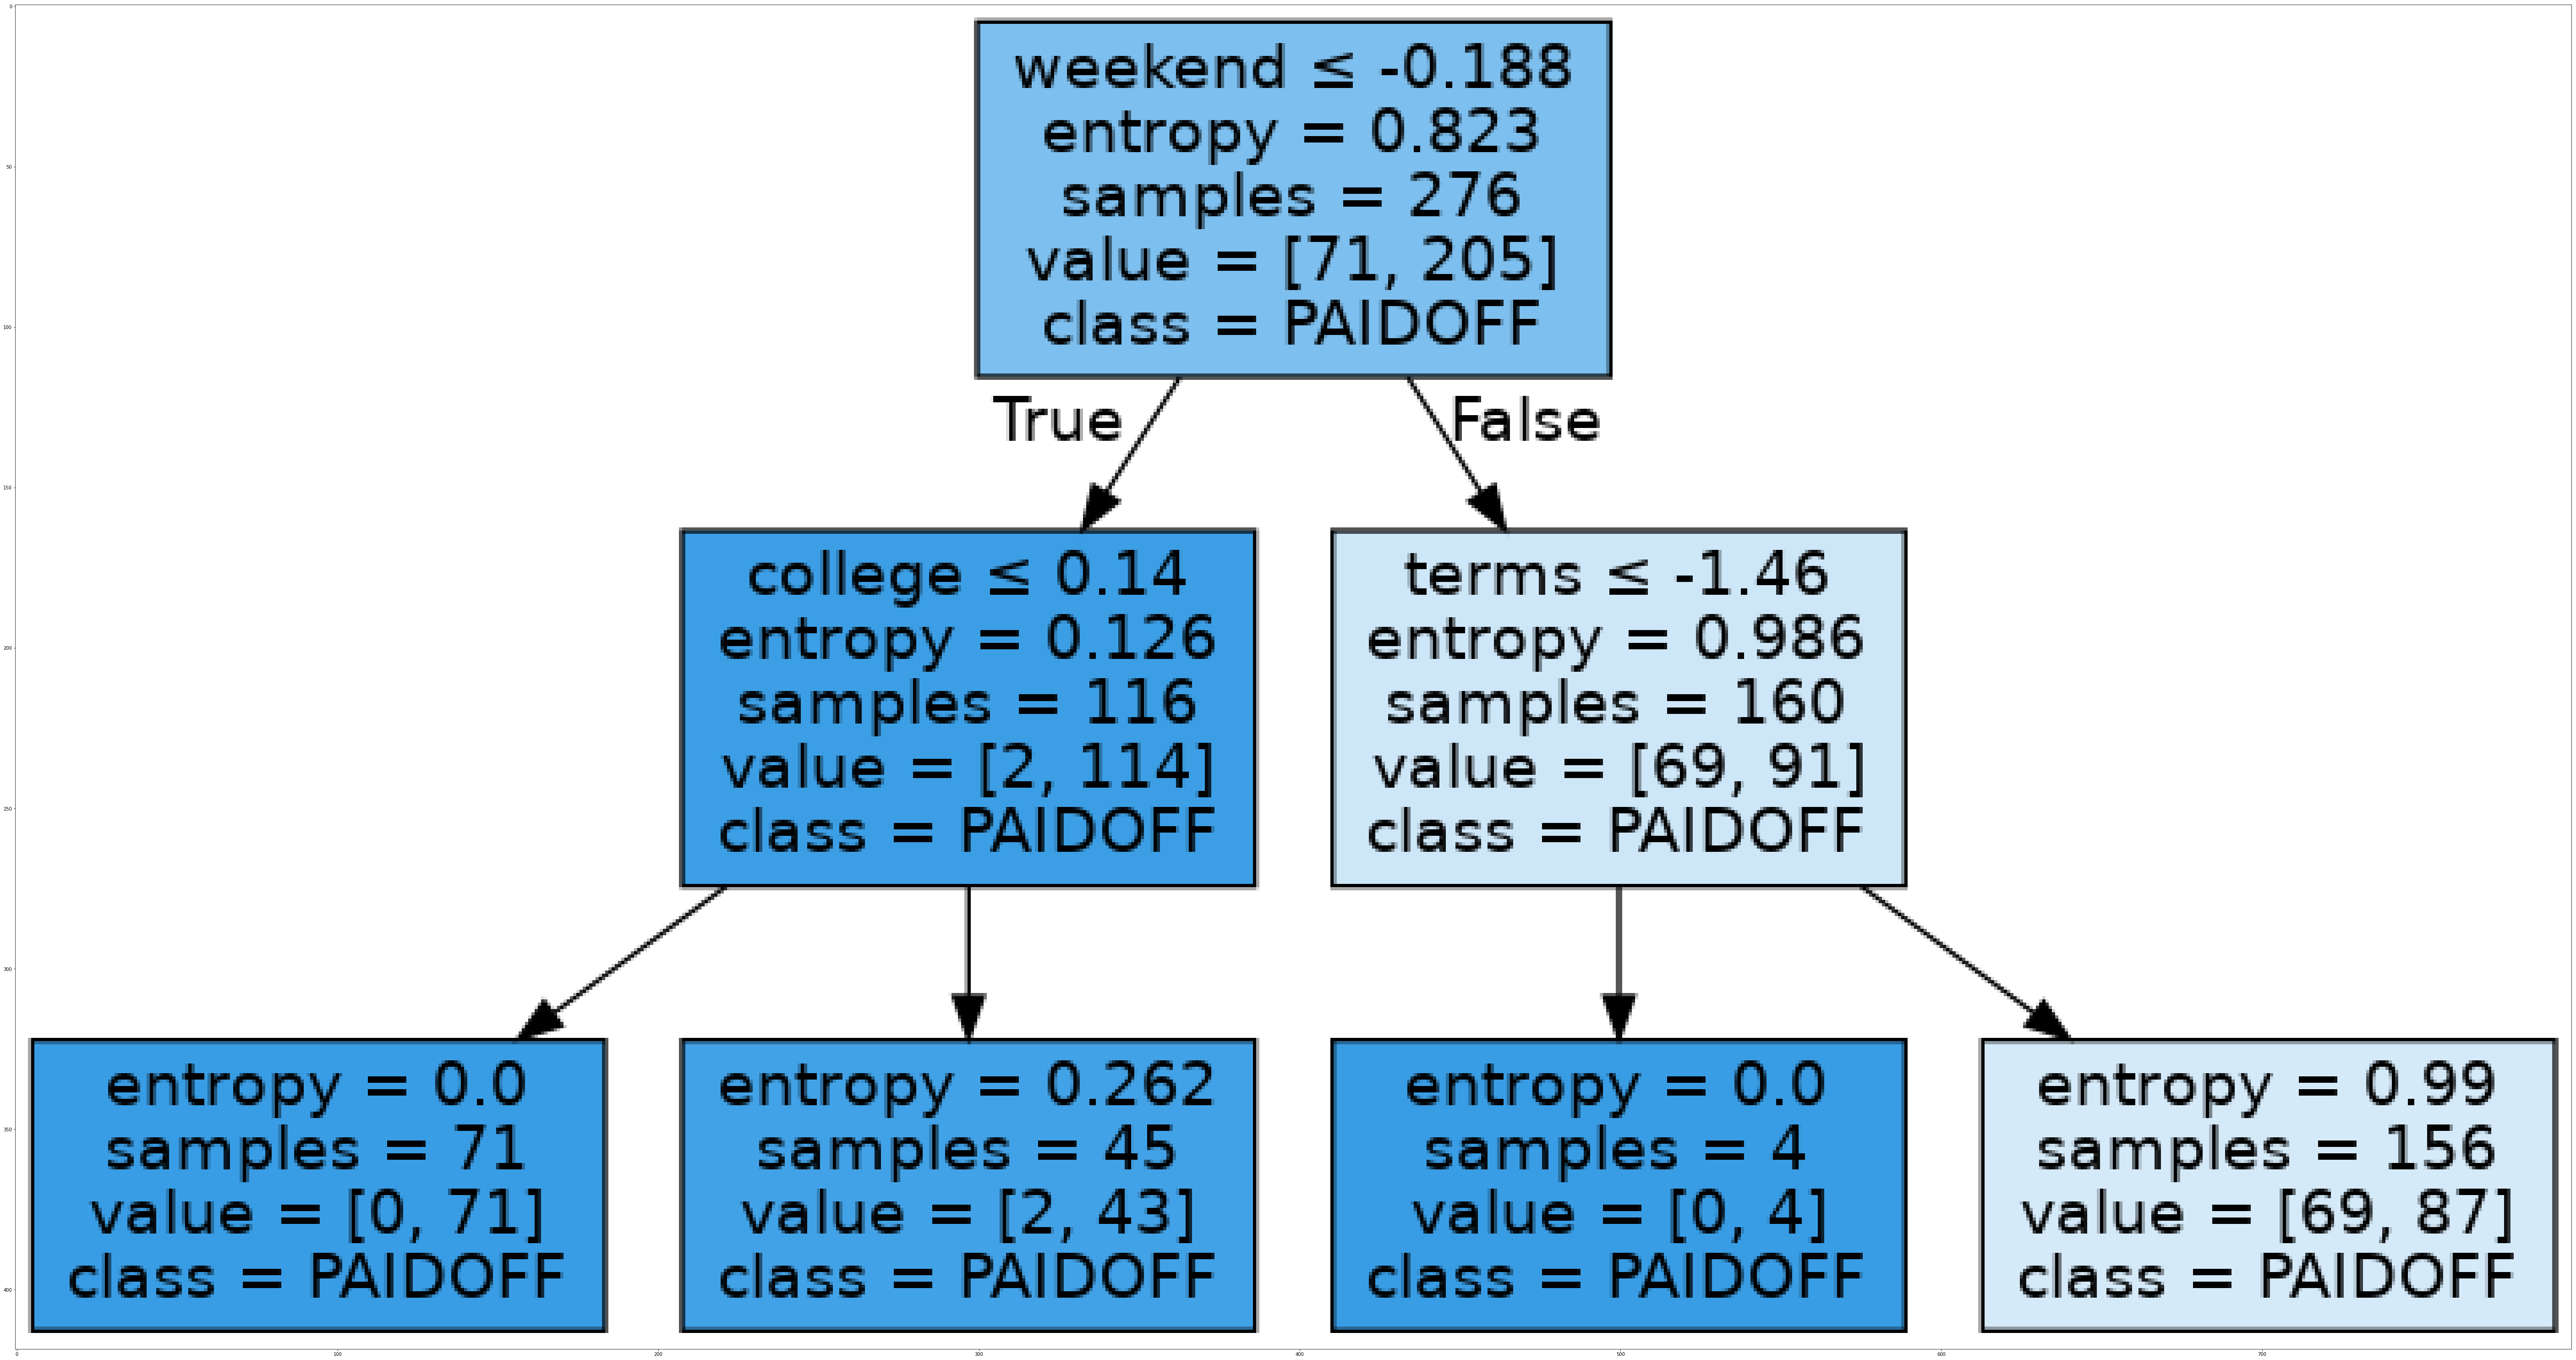

In [30]:
# Depth 2 tree
loanTree2 = DecisionTreeClassifier(criterion="entropy", max_depth = 2)
loanTree2.fit(x_train, y_train) # fitting the data
# Predict the model, show accuracy score
yHat = loanTree2.predict(x_test)
print(metrics.accuracy_score(y_test, yHat))

# Make the image
dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns
targetNames = df['loan_status'].unique().tolist()
out = tree.export_graphviz(loanTree2, feature_names = featureNames, 
                           out_file = dot_data, class_names = np.unique(y_train), 
                           filled = True,  special_characters = True,rotate = False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize = (100, 200))
plt.imshow(img, interpolation='nearest')

Trees with depths 1 and 2 both used "Weekend" variable as the first divider. Since it is a strong determinant of the result, it greatly reduced the entropy of the data in the model.   
As we can see, tree with depth 2, which then used "College" and "Term" as the second level dividers, attained full information gain in two leaves of the lowest level. This is awesome, so we will use **2** as the maximum depth for our model. 

In [31]:
tree_final = DecisionTreeClassifier(criterion="entropy", max_depth = 2).fit(x_train, y_train)

# Support Vector Machine

In [32]:
from sklearn import svm

# Functions to try
functions = ['linear', 'poly', 'rbf', 'sigmoid']
acc_score = np.zeros((len(functions)))

# Try each function and compare their accuracy rates
for n in range(0,len(functions)):
    
    # Fit the model using this particular function
    svm_loan = svm.SVC(kernel = functions[n])
    svm_loan.fit(x_train, y_train)
    
    # Predict test set values, compute accuracy score
    yHat = svm_loan.predict(x_test)
    acc_score[n] = metrics.accuracy_score(y_test, yHat)

print(acc_score)

[0.78571429 0.77142857 0.74285714 0.74285714]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


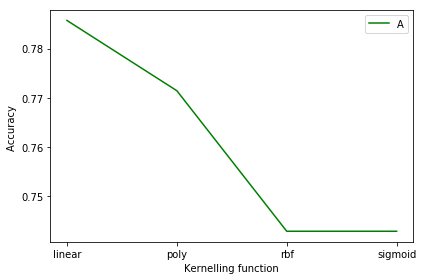

In [33]:
# Plot the accuracy score for each function's model
plt.plot(functions, acc_score, 'g')
plt.legend(('Accuracy '))
plt.ylabel('Accuracy ')
plt.xlabel('Kernelling function')
plt.tight_layout()
plt.show()

Apparently, our model yields the highest accuracy rate when using the linear kernelling function. Let's thus set **linear** as the kernelling function for our model. 

In [34]:
svm_final = svm.SVC(kernel = 'linear').fit(x_train, y_train)

# Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

# solvers and regulation values to try
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
regVals = [0.01, 0.1, 1, 10]

acc_scores = pd.DataFrame(columns = solvers, index = regVals)
acc_scores

,newton-cg,lbfgs,liblinear,sag,saga
0.01,NaN,NaN,NaN,NaN,NaN
0.10,NaN,NaN,NaN,NaN,NaN
1.00,NaN,NaN,NaN,NaN,NaN
10.00,NaN,NaN,NaN,NaN,NaN


In [36]:
# Try all combinations of  and compare their accuracy rates
for row in range(0, len(regVals)):
    for col in range(0, len(solvers)):
    
        # Fit the model using this regulation and this solver
        lr_loan = LogisticRegression(C = regVals[row], solver = solvers[col])
        lr_loan.fit(x_train,y_train)
       
        # Predict test set values, compute accuracy score
        yHat = lr_loan.predict(x_test)
        acc_scores.loc[regVals[row], solvers[col]] = metrics.accuracy_score(y_test, yHat)

acc_scores

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,newton-cg,lbfgs,liblinear,sag,saga
0.01,0.785714,0.785714,0.685714,0.785714,0.785714
0.10,0.771429,0.771429,0.742857,0.771429,0.771429
1.00,0.728571,0.728571,0.714286,0.728571,0.728571
10.00,0.728571,0.728571,0.714286,0.728571,0.714286


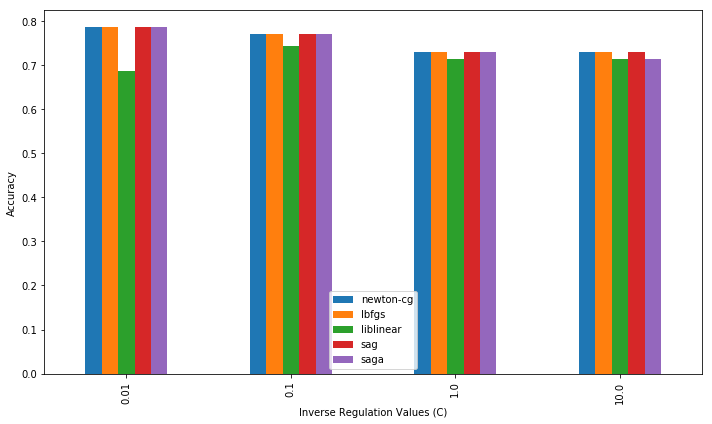

In [37]:
# Plot the accuracy scores
acc_scores.plot(kind = 'bar', figsize = (10, 6))
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Inverse Regulation Values (C)')
plt.tight_layout()
plt.show()

From the C-values I choose, 0.01 has the highest accuracy scores with almost all solvers. Newton-cg, lbfgs, sag, and saga are the most  accurate solvers among all. Therefore, I will be choosing **0.01 as my c-value and Newton-cg as my solver** for this model. 

In [40]:
lr_final = LogisticRegression(C = 0.01, solver = 'newton-cg').fit(x_train, y_train)

# Model Evaluation using Test set

In [60]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [61]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-08-02 03:34:35--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-08-02 03:34:35 (611 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [62]:
test_df = pd.read_csv('loan_test.csv')
test_df.shape

(54, 10)

In [63]:
# Data wrangling
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date']) # convert to date time object

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x:1 if (x>3)  else 0) # label weekdays and weekends
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1], inplace = True) # codify genders

In [64]:
# Determine feature set
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature, pd.get_dummies(test_df['education'])], axis = 1)
test_feature.drop(['Master or Above'], axis = 1, inplace = True)
print(test_feature.shape)

(54, 8)


In [65]:
# Set dependent and independent variables
x = test_feature
x = preprocessing.StandardScaler().fit(x).transform(x)
y = test_df['loan_status'].values

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [66]:
# Initiate a dataframe to store final result
cols = ['Algorithm', 'Jaccard', 'F1-score', 'LogLoss']
algs = ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression']
scores = pd.DataFrame(columns = cols)
scores['Algorithm'] = algs

In [67]:
# KNN
scores.loc[0, 'Jaccard'] = jaccard_similarity_score(y, knn_final.predict(x))
scores.loc[0, 'F1-score'] = f1_score(y, knn_final.predict(x), average='weighted')

# Decision Tree
scores.loc[1, 'Jaccard'] = jaccard_similarity_score(y, tree_final.predict(x))
scores.loc[1, 'F1-score'] = f1_score(y, tree_final.predict(x), average='weighted')

# SVM
scores.loc[2, 'Jaccard'] = jaccard_similarity_score(y, svm_final.predict(x))
scores.loc[2, 'F1-score'] = f1_score(y, svm_final.predict(x), average='weighted')

# Logistic Regression
scores.loc[3, 'Jaccard'] = jaccard_similarity_score(y, lr_final.predict(x))
scores.loc[3, 'F1-score'] = f1_score(y, lr_final.predict(x), average='weighted')
scores.loc[3, 'LogLoss'] = log_loss(y, lr_final.predict_proba(x))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.666667,0.63284,NaN
1,Decision Tree,0.740741,0.630418,NaN
2,SVM,0.740741,0.630418,NaN
3,LogisticRegression,0.740741,0.630418,0.516366


# Report

In [ ]:
# Show the final result
scores

As the table shows, **Decision Tree**, __SVM__, and __Logistic Regression__ yield similar accuracy scores. I will be choosing models within these three according to real-life contexts. 

**Acknowledgment: The original content belongs to the following**
<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>